In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

✅ Dataset loaded. Rows: 1000

Sample cleaned resume (first 500 chars):
1

Cleaned job description:
data scientist needed with strong python machine learning nlp and data analysis skills looking for experience with pandas sklearn tensorflow cloud statistics and reporting

Common words between sample resume and JD: set()


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📁 Enhanced report saved to 'enhanced_resume_match_report.csv'.
📂 Top 5 resumes exported to 'Top_Resumes/' folder.

📊 Top 5 Matching Resumes (with Name, No., and skill match breakdown):

Rank 1: Name=Miguel Robbins, No.=390, Score=0.1277, Skills=, Skill_Match_Count=0
Rank 2: Name=Bryan Wright, No.=259, Score=0.1261, Skills=, Skill_Match_Count=0
Rank 3: Name=Caitlin Shaw, No.=249, Score=0.1223, Skills=, Skill_Match_Count=0
Rank 4: Name=Kimberly Thompson, No.=333, Score=0.1188, Skills=, Skill_Match_Count=0
Rank 5: Name=Frances Davis MD, No.=18, Score=0.1181, Skills=, Skill_Match_Count=0

📝 Full Candidates Table (All Rows):


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100),Cleaned_Resume,Match_Score,Matched_Skills,Skill_Match_Count,Rank
0,390,Miguel Robbins,"Deep Learning, Python, SQL, Machine Learning",1,PhD,AWS Certified,Data Scientist,Reject,84131,3,55,390,0.127744,,0,1
1,259,Bryan Wright,"SQL, Machine Learning, Deep Learning",0,B.Tech,Deep Learning Specialization,Data Scientist,Reject,113435,2,35,259,0.126121,,0,2
2,249,Caitlin Shaw,"SQL, Java, React, C++",4,MBA,Deep Learning Specialization,Software Engineer,Hire,101488,5,95,249,0.122313,,0,3
3,333,Kimberly Thompson,"TensorFlow, Pytorch",5,PhD,AWS Certified,AI Researcher,Hire,79405,4,90,333,0.118803,,0,4
4,18,Frances Davis MD,"Linux, Networking, Cybersecurity, Ethical Hacking",3,B.Tech,NaN,Cybersecurity Analyst,Hire,66379,6,80,18,0.118078,,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,754,Kevin Carlson,"Machine Learning, Python, Deep Learning",0,B.Tech,Deep Learning Specialization,Data Scientist,Reject,91454,1,30,754,-0.035757,,0,996
996,757,Michelle Nolan,"Python, Pytorch, TensorFlow, NLP",6,PhD,Deep Learning Specialization,AI Researcher,Hire,71832,4,100,757,-0.040712,,0,997
997,802,James Baker,"Networking, Ethical Hacking",6,B.Sc,Deep Learning Specialization,Cybersecurity Analyst,Hire,107340,7,100,802,-0.041992,,0,998
998,733,Vicki Murphy,"SQL, Machine Learning, Deep Learning, Python",5,PhD,AWS Certified,Data Scientist,Hire,91828,10,100,733,-0.042011,,0,999


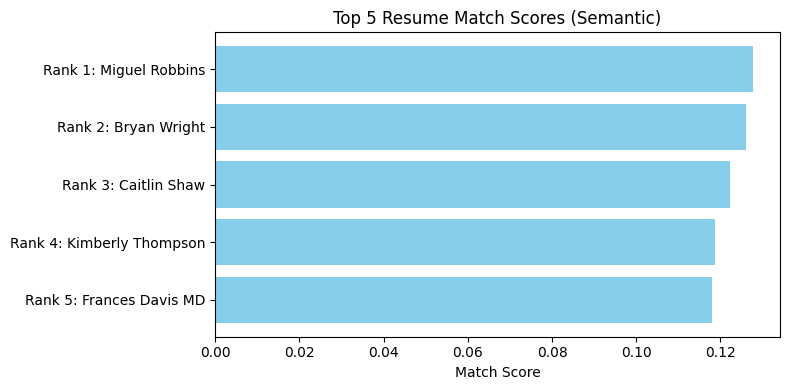

In [3]:
import pandas as pd
import string
import os
from sentence_transformers import SentenceTransformer
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

# --- 1. Load Data ---
data = pd.read_csv("/kaggle/input/prodataset1/AI_Resume_Screening.csv").dropna(subset=['Resume_ID'])
print("✅ Dataset loaded. Rows:", len(data))

# --- 2. Clean Text Function ---
def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join(text.split())

data['Cleaned_Resume'] = data['Resume_ID'].apply(clean_text)

# --- 3. Job Description (EDIT THIS SECTION as needed) ---
job_description = """
Data Scientist needed with strong Python, machine learning, NLP, and data analysis skills.
Looking for experience with pandas, sklearn, tensorflow, cloud, statistics, and reporting.
"""
cleaned_jd = clean_text(job_description)
jd_keywords = set(cleaned_jd.split())

# --- 4. Show sample resume and JD for debugging ---
print("\nSample cleaned resume (first 500 chars):")
print(data['Cleaned_Resume'].iloc[0][:500])
print("\nCleaned job description:")
print(cleaned_jd)
print("\nCommon words between sample resume and JD:", set(data['Cleaned_Resume'].iloc[0].split()) & jd_keywords)

# --- 5. Semantic Matching with Sentence Transformers ---
model = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeddings = model.encode(data['Cleaned_Resume'].tolist(), convert_to_tensor=False)
jd_embedding = model.encode([cleaned_jd], convert_to_tensor=False)

def cos_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))

data['Match_Score'] = [cos_sim(res_emb, jd_embedding[0]) for res_emb in resume_embeddings]

# --- 6. Skill Matching (addon) ---
def matched_skills(text): return ', '.join(sorted(set(text.split()) & jd_keywords))
data['Matched_Skills'] = data['Cleaned_Resume'].apply(matched_skills)
data['Skill_Match_Count'] = data['Matched_Skills'].apply(lambda x: 0 if not x else len(x.split(', ')))

# --- 7. Rank, Export Results ---
ranked = data.sort_values(by='Match_Score', ascending=False).reset_index(drop=True)
ranked['Rank'] = ranked.index + 1  # Add Rank column

# Make sure the display columns match your CSV
display_cols = [
    'Resume_ID', 'Name', 'Skills', 'Experience (Years)', 'Education', 'Certifications', 
    'Job Role', 'Recruiter Decision', 'Salary Expectation ($)', 'Projects Count', 
    'AI Score (0-100)', 'Cleaned_Resume', 'Match_Score', 'Matched_Skills', 'Skill_Match_Count', 'Rank'
]
# Ensure columns exist (fill with N/A if missing for compatibility)
for col in display_cols:
    if col not in ranked.columns:
        ranked[col] = "N/A"

# Save enhanced CSV report
ranked[display_cols].to_csv("enhanced_resume_match_report.csv", index=False)
print("\n📁 Enhanced report saved to 'enhanced_resume_match_report.csv'.")

# --- 8. Export Top Resumes as Files (addon) ---
os.makedirs("Top_Resumes", exist_ok=True)
for i in range(min(5, len(ranked))):
    with open(f"Top_Resumes/Rank_{i+1}_Resume.txt", 'w', encoding='utf-8') as f:
        f.write(str(ranked.loc[i, 'Resume_ID']))
print("📂 Top 5 resumes exported to 'Top_Resumes/' folder.")

# --- 9. Print Top Matches with Name, No., Skill Breakdown (addon) ---
print("\n📊 Top 5 Matching Resumes (with Name, No., and skill match breakdown):\n")
for i in range(5):
    r = ranked.loc[i]
    print(f"Rank {i+1}: Name={r['Name']}, No.={r['Resume_ID']}, Score={r['Match_Score']:.4f}, Skills={r['Matched_Skills']}, Skill_Match_Count={r['Skill_Match_Count']}")

# --- 10. Display Full Table of All Candidates in Notebook Format ---
try:
    from IPython.display import display
    print("\n📝 Full Candidates Table (All Rows):")
    display(ranked[display_cols])
except ImportError:
    # If not in a notebook, print as text table
    print("\n📝 Full Candidates Table (All Rows):")
    print(ranked[display_cols].to_string(index=False))

# --- 11. Visualization (addon) ---
plt.figure(figsize=(8, 4))
plt.barh(range(1,6), ranked['Match_Score'][:5], color='skyblue')
plt.yticks(range(1,6), [f"Rank {i+1}: {ranked.loc[i, 'Name']}" for i in range(5)])
plt.xlabel("Match Score")
plt.title("Top 5 Resume Match Scores (Semantic)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()